# Lecture 14 - Co-expression networks and enrichment analysis

In this lecture you learned how to obtain biological insight from omics data by creating co-expression networks and performing enrichment analysis.

In this tutorial we will continue to use the dataset from the previous lecture [(Lee et al, 2016)](https://www.sciencedirect.com/science/article/pii/S1550413116302480) that analysed gene expression levels of liver and adipose tissue of 12 obese patients undergoing bariatric surgery.

This time we will use the *"cleaned up"* version of the data that we generated last time.

In [1]:
import pandas as pd
data = pd.read_csv('files/E-GEOD-83322_clean.tsv', sep='\t')
data.sample(5)

,gene,value,patient,tissue
156699,SGSH,34.0,1054,adipose tissue
94251,PYCARD,3.0,1038,liver
109166,TRAPPC12,12.0,1040,adipose tissue
21213,RRN3P3,4.0,1008,liver
236173,DCAF10,6.0,1061,liver


## Exercise 1: gene co-expression networks

Let's search for genes that are co-expressed across all patients on liver samples. 

To make our life easier, let's filter by tissue and convert the table to wide format:

In [2]:
df_liver = data.query('tissue == "liver"').pivot(index='gene', columns='patient', values='value')

Now iterate (twice) over all genes to calculate the Spearman correlation between every pair of genes, storing the results in the format you find most appropriate.

> Note: the dataset contains **> 12k genes**, resulting in about **150 million** pairs. To make things faster, we will only use **100** (randomly selected) genes. 

> Also: note that we only need to compute half the number of combinations. The correlation of (gene1, gene2) is the same as that of (gene2, gene1).

In [40]:
from scipy.stats import spearmanr

df_liver = df_liver.sample(100) # sample 100 random genes

In [27]:
# type your code here

Click below to see solution:

In [41]:
%%time  
# this is just to print the total computation time

corr = []
for i in range(len(df_liver)):
    for j in range(i+1, len(df_liver)):
        gene1 = df_liver.index[i]
        gene2 = df_liver.index[j]
        values1 = df_liver.iloc[i,:]
        values2 = df_liver.iloc[j,:]
        r, p = spearmanr(values1, values2)
        corr.append((gene1, gene2, r, p))
        
corr = pd.DataFrame(corr, columns=['gene1', 'gene2', 'r', 'p'])

CPU times: user 4.92 s, sys: 34.5 ms, total: 4.96 s
Wall time: 5.07 s


Now filter only the gene pairs with an absolute correlation above 0.8, and plot the co-expression network using [Pyvis](https://pyvis.readthedocs.io/en/latest/).

> Remember: you have already used Pyvis in Lecture 9, Exercise 2. You can go back and see how to use it.

In [43]:
# type your code here...

Click below to see solution:

In [42]:
selected = corr.query("abs(r) > 0.8")

from pyvis.network import Network
net = Network(directed=False, notebook=True, height='300px', width='500px')

net.add_nodes(selected['gene1'])
net.add_nodes(selected['gene2'])
net.add_edges(selected[['gene1', 'gene2']].values)

net.show('tmp.html')

Remember that we used 100 randomly selected genes, so try running a second time with a different selection.

## Exercise 2: Gene enrichment analysis

In this exercise, we will search for genes that are over or under-expressed in adipose tissue compared to liver samples.

We will begin with some pandas magic to compute fold-change, p-values, and adjusted p-values (also known as q-values).

In [174]:
df = data.pivot(index='gene', columns=['tissue','patient'], values='value').droplevel(1, axis=1)
df['FC'] = df['adipose tissue'].mean(axis=1) / df['liver'].mean(axis=1)

from scipy.stats import ttest_ind
df['p'] = df.apply(lambda x: ttest_ind(x['liver'], x['adipose tissue'])[1], axis=1)

from statsmodels.stats.multitest import fdrcorrection
df['is_significant'], df['q'] = fdrcorrection(df['p'])

Now draw a volcano plot as follows:

- use *log2(fold-change)* on the x-axis and *-log10(q-value)* on the y-axis
- you can import *log2* and *log10* from *numpy*
- you can use *df.plot.scatter()* if you store the results as new columns

In [157]:
# type your code here

Click to see solution below:

<AxesSubplot:xlabel='log2FC', ylabel='log10q'>

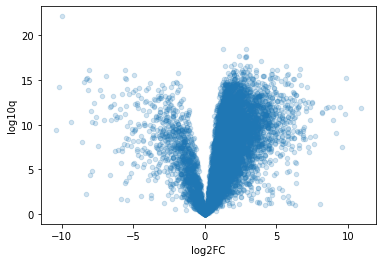

In [176]:
df['log2FC'] = np.log2(df['FC'])
df['log10q'] = -np.log10(df['q'])
df.plot.scatter('log2FC', 'log10q', alpha=0.2)

In [170]:
up_reg = df.query('FC > 10 and q < 0.05').index

In [172]:
down_reg = df.query('FC < 0.1 and q < 0.05').index

In [171]:
print(' '.join(up_reg))

A4GALT AACS ABCA3 ABCC1 ABI3BP ABR AC005747.1 AC020916.1 AC022007.1 AC040160.1 AC093278.2 ACE ACER3 ACKR3 ACVR1C ACVRL1 ADA ADAM33 ADAM9 ADAMTS1 ADAMTS10 ADAMTS12 ADAMTS2 ADAMTS4 ADAMTS5 ADAMTS7 ADAMTSL1 ADCY3 ADCY4 ADCY7 ADGRA2 ADGRF5 ADGRG1 ADGRL1 ADGRL4 ADIRF-AS1 ADM AEBP1 AFAP1 AFAP1L1 AHNAK AIF1L AIFM2 AKAP12 ALDOA ALOX5AP AMOT AMOTL2 ANGPT2 ANGPTL2 ANK2 ANKDD1A ANKRD13B ANKRD29 ANTXR1 ANXA1 ANXA2 ANXA3 ANXA5 AOC2 AOC3 AP001528.2 APBB1IP APCDD1 APOD APOLD1 AQP1 AQP7 ARHGAP20 ARHGAP31 ARHGAP6 ARHGEF15 ARHGEF2 ARHGEF6 ARID5B ARL2 ARMCX1 ASAH1 ASAP2 ASPH ATP10A ATP1A2 ATP1B3 ATP2B4 ATP6V0E2-AS1 BACE2 BAG3 BCL6B BEST1 BHLHE41 BLVRA BMP6 BTG2 BTNL9 C11orf96 C14orf180 C1QTNF1 C1QTNF7 C1orf198 C20orf194 C2CD2 C6orf141 CA3 CAB39L CACHD1 CACNA2D1 CACNB1 CACNB3 CALHM2 CAP2 CAPG CAPN2 CARMN CAV1 CAV2 CAVIN1 CAVIN2 CC2D2A CCDC3 CCDC69 CCDC80 CCL2 CCM2L CCN2 CCND2 CD209 CD248 CD34 CD36 CD44 CD83 CD93 CDH13 CDH24 CDH5 CDH6 CDKN1C CDKN2C CELF2 CEP112 CEP68 CERCAM CFD CHD3 CHMP3 CHRDL1 CHST2 CHST

In [173]:
print(' '.join(down_reg))

ABAT ABCB4 ABCC2 ABCC6P1 AC006254.1 AC008760.2 ADCY1 ADGRG5 ADH1C AGMO AGT AKR7L ALB ALDH8A1 ANG APOB APOC1 APOM ASGR1 ASGR2 ASPG ATF5 AZGP1 BBOX1 BCHE BCO2 BDH1 BHMT C5 C6 CA2 CES3 CFB CFI CLDN1 CP CPS1 CTH CYP2A6 CYP2B7P CYP2D7 CYP2E1 CYP3A5 CYP4F3 DCXR DEPDC7 DSP EBP EHHADH ELOVL2 ENO3 ETNK2 F5 FBP1 FCN3 FGFR3 FITM1 FMO3 FMO5 GAMT GAS2 GATM GLYCTK GNAO1 GRB14 GREB1 HAAO HAL HOMER2 HP HPD HPGD HPN HPX HSD17B13 HULC HYAL1 IGFALS IL17RB IL1RAP IRF6 KDM8 KHK KRT18 KRT8 LEAP2 LGALS4 LINC01127 LINC01554 LIPC LMO7 LPAL2 LRG1 MAMDC4 MASP2 MSMO1 MST1 MST1L MST1P2 MT1G MYCL NECAB2 NIPSNAP1 NUGGC OXER1 PANK1 PBLD PCK2 PCSK6 PIPOX PON3 PPP1R3C PROX1 PRRG4 PZP QPRT RBP1 RBP5 REEP6 RGN RIDA RORC SARDH SDS SEC14L2 SEMA4G SERPINA1 SERPINA5 SERPINF2 SHROOM3 SLC13A3 SLC16A13 SLC17A9 SLC25A15 SLC27A5 SLC38A3 SLC39A14 SLC47A1 SLC6A1 SORD STAP2 STARD10 SYT7 TF TMEM184A TMEM97 TTPA UNC5CL VNN1 XYLB
